# [E-13] CIFAR-10 이미지 생성하기

# 0. 시작하기전,,

## GAN이란?
GAN(Generative Adversarial Networks)는 생성모델중 하나로 두개의 모델이 적대적인(adversarial) 과정을 통해 동시에 훈련되는 모델이다.  
- 생성자(Generator) : 랜덤 노이즈로 부터 진짜처럼 보이는 이미지를 생성하도록 학습 (ex. 위조지페를 만듬)
- 판별자(Discriminator) : 생성자(Generator)가 만든 이미지를 진짜와 구별하는 것을 학습 (ex. 위조지페를 잡아냄)

![](https://tensorflow.org/tutorials/generative/images/gan1.png?hl=ko) 


훈련과정 동안 생성자는 점점 더 진짜 같은 이미지를 생성하게 되고, 감별자는 점점 더 진짜와 가짜를 잘 구별하게 된다. 이 과정에서 감별자가 가짜와 진짜를 더이상 구별하지 못하게 될때, 평형상태에 도달하게 된다.

![](https://tensorflow.org/tutorials/generative/images/gan2.png?hl=ko)

[출처](https://www.tensorflow.org/tutorials/generative/dcgan?hl=ko)
## DCGAN
https://www.tensorflow.org/tutorials/generative/dcgan?hl=ko
## CycleGAN
https://www.tensorflow.org/tutorials/generative/cyclegan?hl=ko
## 그외 생성모델,,
### Neural Style Transfer
https://www.tensorflow.org/tutorials/generative/style_transfer?hl=ko
### Pix2Pix
https://www.tensorflow.org/tutorials/generative/pix2pix?hl=ko




---

# 1. 데이터셋 구성하기

## 1.1 데이터 살펴보기

시작하기전 CIFAR-10 데이터에 대하여 알아보자.  
#### CIFAR-10
Keras에서 제공하는 dataset으로 32X32픽셀의 60000(train : 50000, test : 10000)개 컬러이미지가 포함되어있으며, 각 이미지는 10개의 클래스로 라벨링이 되어있다. 또한, MNIST와 같이 머신러닝 연구에 가장 널리 사용되는 dataset중 하나이다.  
![](https://paperswithcode.com/media/datasets/CIFAR-10-0000000431-b71f61c0_U5n3Glr.jpg)
[출처](https://www.cs.toronto.edu/~kriz/cifar.html)

## 1.2 데이터 로딩 및 준비

### 데이터 불러오기

In [46]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.4.1


In [94]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

### 데이터 전처리(정규화 : normalization)

In [95]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


CIFAR은 32x32x3 픽셀 이미지로, 각 픽셀은 0~255사이의 정숫값을 가지며 컬러이미지이다.  
본 프로젝트에서는 각 픽셀을 -1, 1로 정규화를 시켜서 사용할 것이다.  

In [96]:
train_x.shape

(50000, 32, 32, 3)

training data는 위에 설명대로 50000개의 data가 있으며 컬러 이미지이기 때문에 3개의 채널(RGB)을 가지고 있다. 

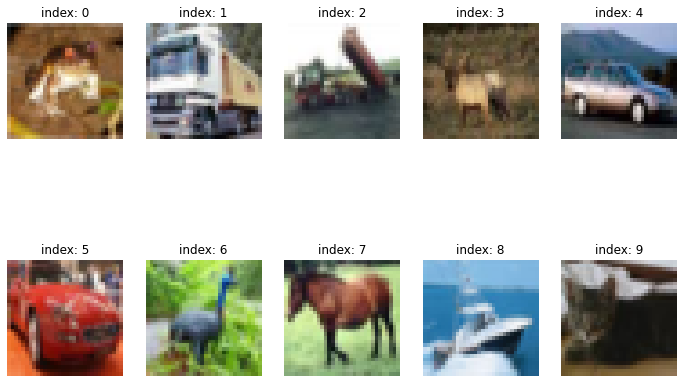

In [97]:
plt.figure(figsize=(12, 8))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i], cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

In [98]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다. (중간값을 0으로)

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

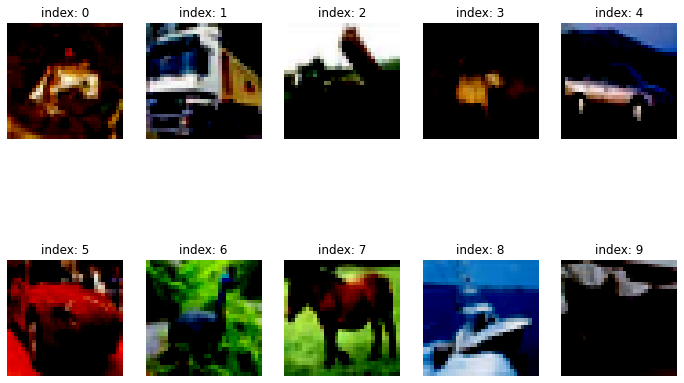

In [99]:
plt.figure(figsize=(12, 8))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i], cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

### 미니배치 학습을 위한 데이터 배치 생성

In [100]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [101]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 2. 모델 만들기

## 2.1 생성자 모델

노이즈로 부터 이미지를 생성한다!
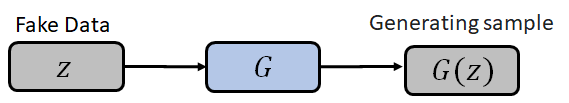

In [102]:
def make_generator_model(in_shape=(32, 32, 3)):

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [103]:
generator = make_generator_model()

generator.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_21 (Batc (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_21 (Conv2DT (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_22 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_38 (LeakyReLU)   (None, 8, 8, 128)       

In [104]:
noise = tf.random.normal([1, 100])

In [105]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

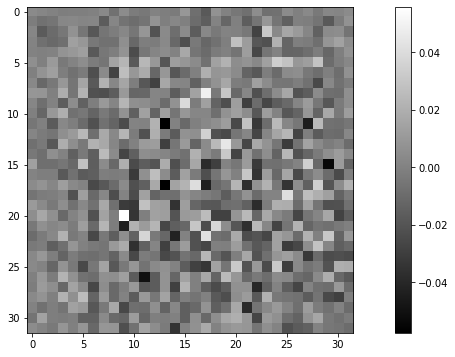

In [106]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

## 2.2 판별자 모델

real이미지와 false이미지를 구분한다!

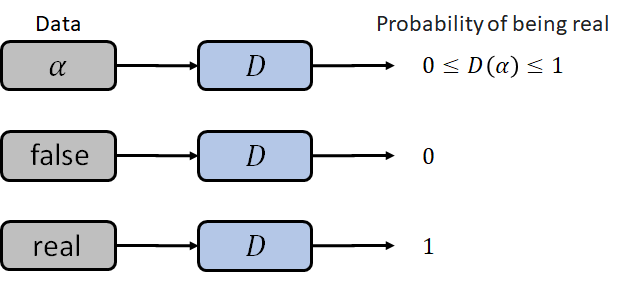

In [107]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [108]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_40 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_41 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 8192)            

In [109]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00494788]], dtype=float32)>

# 3. 손실함수와 옵티마이저 정의

## 3.1 손실함수 (loss function)

GAN은 생성자와 판별자 즉 2명의 플레이어의 Zero-sum Game이다. loss 식은 아래와 같다.    

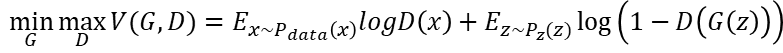
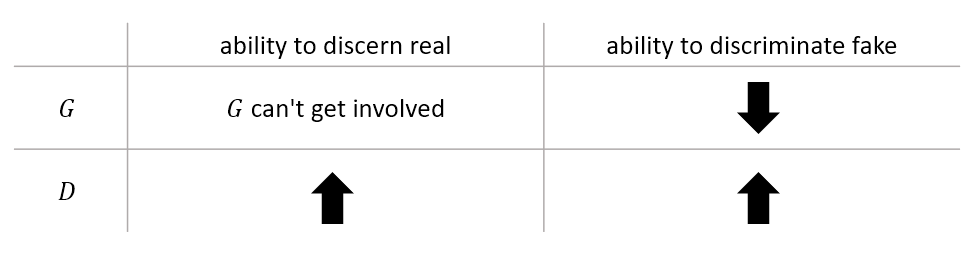
  

### Cross Entropy

GAN은 손실함수로 교차 엔트로피(Cross Entropy)를 사용한다.  
Cross Entropy는 두 값이 얼마나 멀어져있는 지를 정량적으로 계산할 때 쓰인다.  
특히 판별자는 한개의 이미지가 진짜인지 가짜인지 2개의 클래스 분류 문제를 풀어야하므로, 이진 교차 엔트로피(binary cross entropy)를 사용한다.

In [110]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### generator_loss
생성자의 손실함수는 감별자를 얼마나 잘 속였는지에 대해 수치화를 한다. (fake_output이 1에 가까워지게)  

In [111]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### discriminator_loss
반면 판별자의 손실함수는 가짜이미지 와 진짜 이미지를 잘 판단하는지에 대해 수치화 한다.   
(real_output은 1에 가까워지고, fake_output은 0에 가까워지게)  


In [112]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### discriminator accuracy

In [113]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

## 3.2 최적화 함수 (optimizer)

생성자와 판별자는 따로 훈련되기 때문에, 판별자와 생성자의 옵티마이저는 다르다.

In [114]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [115]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

# 4. 훈련과정 설계

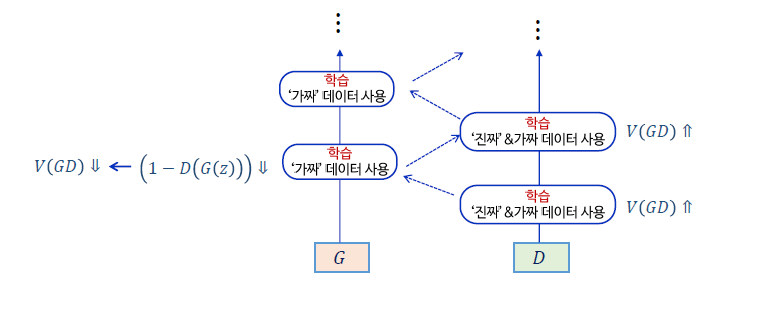

In [116]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [117]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.array(predictions[i]*127.5 + 127.5).astype('uint8')) #(-1,1)로 정규화를 다시 (0,255)로
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [118]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [119]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# 5. 모델 훈련

In [120]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [74]:
save_every = 5
EPOCHS = 500

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

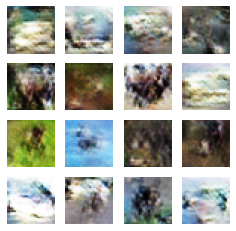

Epoch 270 | iter 151
Time for epoch 270 : 23 sec


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

270 에폭까지 돌려봤지만 결과가 너무 처참하다..  
아무래도 위의 베이스 모델은 28X28X1의 이미지를 만들기위한 모델이니 더 복잡한 32X32X3 이미지를 만들려고하니 역부족이지 않았을 까 싶다.

# 7. GAN 훈련 과정 개선하기

## Try 1 : 파라미터 조정하기

In [121]:
def make_generator_model(in_shape=(32, 32, 3)):

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization(momentum = 0.9))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum = 0.9))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum = 0.9))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [122]:
generator = make_generator_model()

generator.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_24 (Batc (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_8 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_24 (Conv2DT (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_25 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_43 (LeakyReLU)   (None, 8, 8, 128)       

In [123]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    #model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [124]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_45 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)               

In [125]:
generator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

In [126]:
save_every = 5
EPOCHS = 500

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

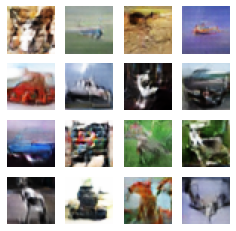

Time for training : 16243 sec


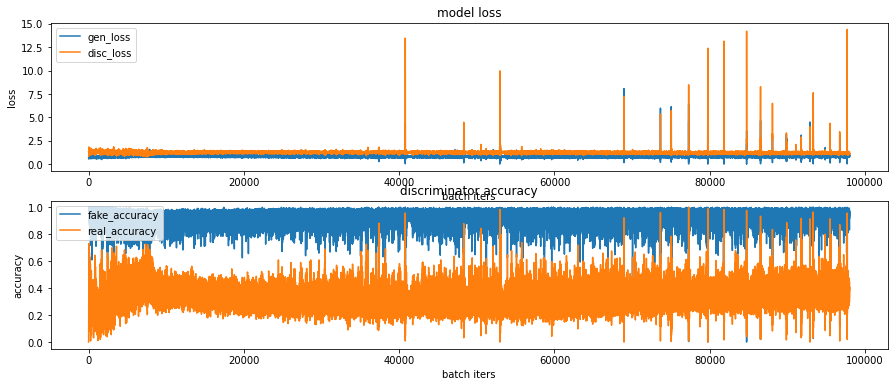

CPU times: user 4h 30min 55s, sys: 4min 12s, total: 4h 35min 8s
Wall time: 4h 30min 47s


In [127]:
%%time
train(train_dataset, EPOCHS, save_every)


In [128]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 3774153 Sep  2 13:08 /aiffel/aiffel/dcgan_newimage/cifar10/fashion_mnist_dcgan.gif


In [138]:
latest

'/aiffel/aiffel/dcgan_newimage/cifar10/training_checkpoints/ckpt-100'

In [136]:
generator.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_21 (Batc (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_21 (Conv2DT (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_22 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_38 (LeakyReLU)   (None, 8, 8, 128)       

## Try2 : 모델 층 늘리기

28X28X1을 생성해낸 모델을 가지고 32X32X3을 샏성하기엔 힘들다고 생각해서 모델 층을 좀더 깊게 설계해보고 싶었다. 하지만 몇가지 시도를 해본결과 GAN에 대해서 제대로 공부하지 않고 모델을 그냥 임의로 막 더 깊게 만드니 오히려 시간만 오래걸릴 뿐 결과도 좋지 않게 나와서 도중에 종료했다. 일찍 이 노드를 시작해서 GAN에 대해 좀 더 공부하고 시도했으면 좋았을 걸 이라는 아쉬움이 남는다.

---
# 회고
||base 모델|개선한 모델|
|-|-|-|
|생성된 이미지|![](https://8888-wnjg4zdcj2kc30gmvdlrp2sum.e.aiffel-2.ainetwork.ai/files/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif)|![](https://8888-wnjg4zdcj2kc30gmvdlrp2sum.e.aiffel-2.ainetwork.ai/files/aiffel/dcgan_newimage/cifar10/fashion_mnist_dcgan.gif)|
|epoch 270|![](https://8888-wnjg4zdcj2kc30gmvdlrp2sum.e.aiffel-2.ainetwork.ai/files/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_0272_iter_051.png)|![](https://8888-wnjg4zdcj2kc30gmvdlrp2sum.e.aiffel-2.ainetwork.ai/files/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_0270_iter_151.png)|


#### 개선된 점
- LeakyReLU(alpha=0.2))
- BatchNormalization(momentum = 0.9)
- Adam(lr=0.0002, beta_1=0.5)

처음 베이스라인 모델을 돌릴 때 시간 때문에 270에폭에서 클라우드가 종료가 돼버렸다. 개선된 모델과 동일한 에폭을 비교해야하나 시간이 부족한 관계로 마저 돌리지 못했다. 그래서 270에폭에서 동일한 사진을 비교 해봤다. 확실히 모델을 개선해준 쪽이 좀더 잘 만들어 낸 것을 볼 수 가 있다.   


아래의 그림은 500에폭을 모두 돌리고 난 후이다. 300정도부터 500까지는 큰 변화는 없고 점점 선명해지기만 했다.
<img src="https://8888-wnjg4zdcj2kc30gmvdlrp2sum.e.aiffel-2.ainetwork.ai/files/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_0500_iter_195.png" width="600" height="600">

### train history
base 모델
![](https://8888-wnjg4zdcj2kc30gmvdlrp2sum.e.aiffel-2.ainetwork.ai/files/aiffel/dcgan_newimage/fashion/training_history/train_history_0270.png)

개선한 모델
![](https://8888-wnjg4zdcj2kc30gmvdlrp2sum.e.aiffel-2.ainetwork.ai/files/aiffel/dcgan_newimage/cifar10/training_history/train_history_0499.png)



train history를 보았을 때 개선된 모델의 loss가 가끔 커지는 경향이 있다. 그래서 두개의 그래프를 자세하게 비교하기가 어렵다.  
정확도 그래프를 보면 확실히 개선된 모델의 fake accuracy가 잘 나오는 것을 확인할 수 있다.

확실히 GAN은 무에서 유를 창조하는 것이고 뭔가 한눈에 변화 되는 것이 보이기때문에 재미있었다. 예전에 TF 튜토리얼을 가지고 발표를 진행했던 적이 있는데 그때는 loss function에만 집중을하고 코드를 복사 붙여 넣어서 제대로 잘 알고 있지는 못했던 것 같다. 그러나 이번 기회에 다른 모델을 넣어 짜보니 좀 더 와 닿았다.  

하지만 여전히 아쉬운 점은 있다. 무엇보다 아쉬운 점은 시간부족으로 인해 좀 더 모델을 뜯어 볼 수 없었다는 것, 좀 더 많은 시도를 해보지 못한 것 등이다..  
또 체크포인트가 베이스모델은 잘 저장되었는데, 개선된 모델은 저장의 오류가 있어서 생성을 해볼려고하니 그냥 노이즈 값이 나왔다. 원인이 정확하게 뭔지 모르겠고, 한번 돌리는데 4시간 30분을 썼는데 또 돌릴 수는 없었다.   
CIFAR10 데이터는 pytoch를 이용해서 GAN을 이용하던데 다음에 GAN모델도 깊게 공부하면 pytoch로도 한번 짜보고 싶다. 